Running SimPEG 1D simulation for Half-Space model...
Simulation complete.

Running SimPEG 1D simulation for Multi-Layer model...
Simulation complete.

Generating plot...


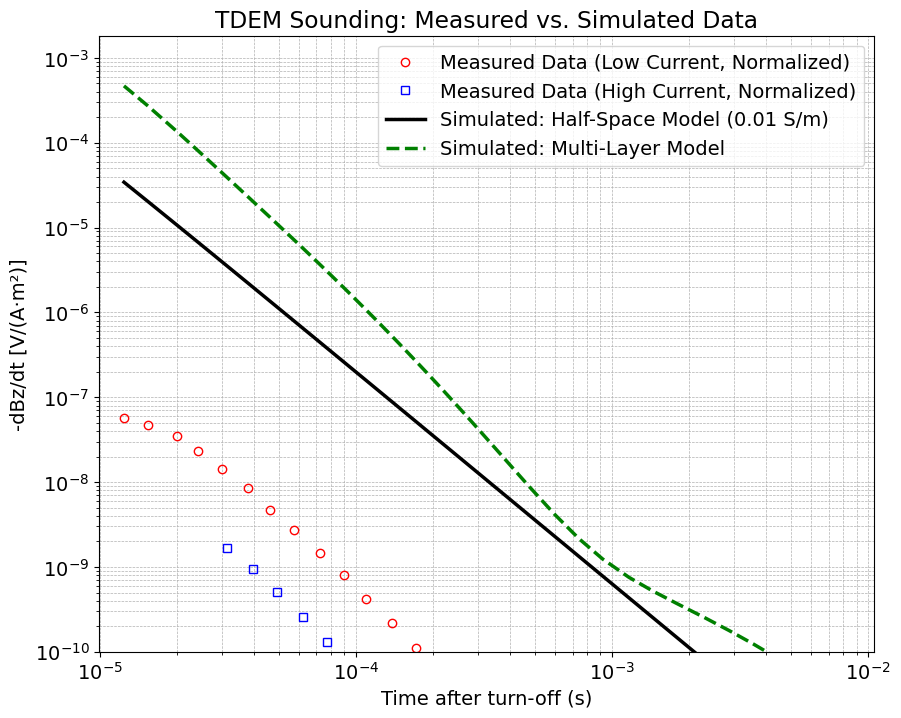

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps

df_lm = pd.read_csv('Dataset_S_LM.csv')
df_hm = pd.read_csv('Dataset_S_HM.csv')

time_lm = df_lm['Time'].values
dbdt_lm = df_lm['dB/dt'].values
time_hm = df_hm['Time'].values
dbdt_hm = df_hm['dB/dt'].values

current_lm = 1.0
current_hm = 10.0
normalized_dbdt_lm = dbdt_lm / current_lm
normalized_dbdt_hm = dbdt_hm / current_hm

time_channels = np.unique(np.sort(np.concatenate((time_lm, time_hm))))
source_location = np.array([0., 0., 0.])
source_radius = 20.0
receiver_locations = np.array([[0., 0., 0.]])
receiver_orientation = "z"

waveform = tdem.sources.StepOffWaveform(off_time=0.0)
receiver_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_locations, time_channels, orientation=receiver_orientation
    )
]
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        radius=source_radius,
        current=1.0
    )
]
survey = tdem.Survey(source_list)

halfspace_conductivity = 1e-2

rho = np.array([
    10.4, 50.1, 61.3, 33.4, 27.0, 104, 303, 571, 778, 841, 751,
    545, 296, 105, 20.6, 5.11, 11.6, 16.0, 16.8, 17.6
])
thk = np.array([
    6.06, 6.84, 7.72, 8.72, 9.85, 11.1, 12.6, 14, 16, 18.1,
    21, 23, 26, 29.3, 33.1, 37.4, 42.1, 47.7, 53.8
])

multilayer_conductivity = 1.0 / rho

simulation_hs = tdem.simulation_1d.Simulation1DLayered(
    survey=survey, thicknesses=[], sigmaMap=maps.IdentityMap(nP=1)
)
print("Running SimPEG 1D simulation for Half-Space model...")
dpred_hs = simulation_hs.dpred(np.array([halfspace_conductivity]))
print("Simulation complete.")

simulation_multilayer = tdem.simulation_1d.Simulation1DLayered(
    survey=survey, thicknesses=thk, sigmaMap=maps.IdentityMap(nP=len(rho))
)
print("\nRunning SimPEG 1D simulation for Multi-Layer model...")
dpred_multilayer = simulation_multilayer.dpred(multilayer_conductivity)
print("Simulation complete.")

print("\nGenerating plot...")
mpl.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.loglog(
    time_lm, normalized_dbdt_lm, "ro",
    label="Measured Data (Low Current, Normalized)",
    markersize=6, markerfacecolor='none'
)
ax.loglog(
    time_hm, normalized_dbdt_hm, "bs",
    label="Measured Data (High Current, Normalized)",
    markersize=6, markerfacecolor='none'
)

ax.loglog(
    time_channels, -dpred_hs, "k-", lw=2.5,
    label="Simulated: Half-Space Model (0.01 S/m)"
)
ax.loglog(
    time_channels, -dpred_multilayer, "g--", lw=2.5,
    label="Simulated: Multi-Layer Model"
)

ax.set_xlabel("Time after turn-off (s)")
ax.set_ylabel("-dBz/dt [V/(A·m²)]")
ax.set_title("TDEM Sounding: Measured vs. Simulated Data")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()
ax.set_xlim(time_channels.min() * 0.8, time_channels.max() * 1.2)
ax.set_ylim(bottom=1e-10)
plt.show()